In [1]:
%pylab
%matplotlib inline
import time
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy.time import Time
from astropy.coordinates import AltAz
from astropy.time import TimeDelta
from astropy.coordinates import get_sun
from functools import reduce
import pandas as pd
from tqdm import tqdm

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


# Dynamic Spectra with Beam Correction from Gain($\nu,\theta ,\phi$)

All the healpy code is commented, the package isn't available for Windows.

In [26]:
path_E=r'\Users\msmm1\Documents\Universidad\Trabajo de Grado\Gain_EDGES'
path_M=r'\Users\msmm1\Documents\Universidad\Trabajo de Grado\Gain_MIST'
path_B=r'\Users\msmm1\Documents\Universidad\Trabajo de Grado\Gain_BOWTIE'

### Frequency extrapolation

In [15]:
f=arange(40,121,1)

Temperature spectral index
    
$$\alpha=-\frac{log(T_1/T_2)}{log(\nu_1/\nu_2)}$$

In [7]:
def T_freq(alpha,freq1,freq2,T1):
    '''Takes spectral index (alpha), initial frequency (freq1) and its tempetature (T1), and
       the desired frequency for extrapolation (freq2). Returns the Temperature extrapolation for that frequency'''
    
    return T1*10**(alpha*log10(freq1/freq2))

### Get Galactic longitude (l) and latitude (b) from Haslam Map

The next lines were run on OSX and I extracted the output (Temperature and galactic coordinates) to the files $\textit{T_Hmap.txt}$ and $\textit{GalCoord_HaslamMap.txt}$

In [ ]:
#T_Hmap = hp.read_map("lambda_haslam408_dsds.fits")  reads Haslam Map

In [45]:
T_Hmap=loadtxt('T_Hmap.txt') #Haslam Map Temperatures

In [5]:
#nside = hp.get_nside(T_Hmap)  #nside defines the resolution of the map
#npix = hp.nside2npix(nside)   #number of pixels of the map

#l, b = hp.pix2ang(nside, arange(npix), lonlat=True)   #(l, b) coordinates for each pixel 

In [10]:
gal_lb=loadtxt('GalCoord_HaslamMap.txt')   #(l, b) coordinates for each pixel 

gal_lb[:,0]   #gives the longitude of each pixel

array([ 45., 135., 225., ..., 135., 225., 315.])

In [11]:
g_coord=SkyCoord(gal_lb[:,0]*u.deg, gal_lb[:,1]*u.deg, frame='galactic')   #Each pixel its galactic coordinate with astropy

### Time and location for horizontal coordinates 

We will use the ALMA location and intervals of 6 minutes in a day for our simulation.

In [13]:
Alma_loc = EarthLocation.of_site('ALMA')
start_t=Time('2021-06-14T00:00:00',format='isot')

times6=start_t + TimeDelta(6*60, format='sec')*linspace(0,240,240) #dt=6 min

altaz6 = AltAz(location=Alma_loc, obstime=times6)

### Antenna gain files

The Gain files must be in this order:

$$g_{\nu}=g_{\nu}(\theta,\phi)$$

$$g_{\nu}(\theta,\phi)=\begin{pmatrix}
g_{\nu}(\theta=0,\phi=0) & g_{\nu}(\theta=0,\phi=1) & \cdots & g_{\nu}(\theta=0,\phi=359)\\ 
g_{\nu}(\theta=1,\phi=0) & g_{\nu}(\theta=1,\phi=1) & \cdots & g_{\nu}(\theta=1,\phi=359)\\
 \vdots &  \vdots  &\vdots & \vdots  \\ 
g_{\nu}(\theta=90,\phi=0) & g_{\nu}(\theta=90,\phi=1) & \cdots & g_{\nu}(\theta=90,\phi=359)\\
\end{pmatrix}$$

### $G[\nu,\theta,\phi]$ Matrix

The $G[\nu,\theta,\phi]$ will store the Gain Pattern of each point in the sky ($\theta,\phi$) for each frequency $\nu$. This matrix will decrease the time of computation for the Dynamic Spectra.

In [29]:
#Sort files in right order
#This is only necessary when the files have text or are in the wrong order.

#for i in range (0,len(f)):
#    file='{}{}{}{}'.format(path_B,'\Gain_phi_theta_', f[i], "MHz.csv")
#    x=loadtxt(file, skiprows=1,delimiter=',')   #Theta[0:]
#    #new=concatenate((x[:91,181:],x[:91,2:181]),axis=1)       ###Theta[0,90],phi[0,359]
#    savetxt('{}{}{}.txt'.format(path_B,'\Gain_B_',f[i]), x[:,1:361])

In [31]:
def G_matrix(path,name,size):
    '''Takes the path and name of the Gain File, and the number of files for the frequencies (size).
       Returns the G[nu,theta,phi] matrix, normalized to the maximum value'''

    G_FTP=empty((size,91,360))

    for i in range (size):
        file='{}{}{}.txt'.format(path,name, f[i])
        x=loadtxt(file)
        G_FTP[i]=x

    return G_FTP/amax(G_FTP)    #NORMALIZED to the maximum gain value

In [34]:
Gn_M=G_matrix(path_M,'\Gains-',len(f))
Gn_B=G_matrix(path_B,'\Gain_B_',len(f))
Gn_E=G_matrix(path_E,'\Gain_E_',len(f))

In [40]:
#Gn_M[0]       #First matrix (initial frequency)
#amax(Gn_M)    #Max value from all matrixes
#Gn_M[0,1,0]   #Matrix 0 (first frecuency), theta=0, phi=1

In [42]:
#TEST
#th=[0,1,2]
#ph=[0,3,0]

#Gn_M[0,th,ph]   #This is going to give us the Gain value for the first frequency and each pair of th and ph.

### Dynamic Spectra with gain pattern $G[\nu,\theta,\phi]$

Temperature matrix for the Dynamic Spectra

$$T(\nu,t)=\begin{pmatrix}
T(\nu_1,t_1) & T(\nu_2,t_1) & \cdots & T(\nu_n,t_1)\\ 
 \vdots &  \vdots  &\vdots & \vdots  \\ 
T(\nu_1,t_m) & T(\nu_2,t_m) & \cdots & T(\nu_n,t_m)
\end{pmatrix}$$

Where $T(\nu_n,t_m)$ is the average temperature of the sky for the frequency $\nu_n$ and the time $t_m$, corrected for the beam with the $G[\nu,\theta,\phi]$ matrix.

In [43]:
def DS_G(fs,ts,alfa,G_n):  
    '''Takes frequencies (fs), times in AltAz frame (ts), the spectral index (alpha), and the G[nu,theta,phi] matrix (G_n). 
       Returns the Temperature + Gain matrix (Dinamic Spectra)'''
    
    start = time.time()
    Temps_g=zeros((ts.obstime.size,len(fs)))      #Temperature + Gain Matrix (Empty first)
    
    for i in tqdm(range (ts.obstime.size)):  
    
        aa_coord=g_coord.transform_to(ts[i])      #Galactic Coords of Haslam Map to Altaz Coords
        mask=argwhere(aa_coord.alt>0)             #Only coordinates above the horizon
        T_sky=T_Hmap[mask]                        #Only those temperatures
        
        Th=np.round((90*u.deg-(aa_coord.alt[mask]))/(1*u.deg))    #Thetas to use in same order as Tsky
        Th=Th.value.astype(int)                                   #Int value (dTheta=1deg)
        
        phi=aa_coord.az[mask]                                     #phi's==azimuth
        phi=phi.value.astype(int)                                 #Int value (dphi=1deg)
        
        for j in range (len(fs)): 
            T_f=T_freq(alfa,408,fs[j],T_sky)                #Temperature Extrapolation
            
            gain=G_n[j,Th,phi]/mean(G_n[j,Th,phi])          #Gains of Th and phi in same order as Tsky  
            
            T_f_g=gain*T_f                                  #New T_sky with respective gain (Beam Correction)
            Temps_g[i,j]=mean(T_f_g)                        #Mean temperature

    end = time.time()
    print('Tiempo(min):',(end - start)/60)    
         
    return Temps_g

In [46]:
TG_I=DS_G(f,altaz6,2.5,Gn_M)

100%|██████████| 240/240 [33:25<00:00,  8.35s/it]

Tiempo(min): 33.41792692343394


In [48]:
TG_B=DS_G(f,altaz6,2.5,Gn_B)
TG_E=DS_G(f,altaz6,2.5,Gn_E)

100%|██████████| 240/240 [32:34<00:00,  8.14s/it]


Tiempo(min): 32.57649979194005


100%|██████████| 240/240 [1:18:40<00:00, 19.67s/it] 

Tiempo(min): 78.67911798556646


In [49]:
#Save each Dynamic Spectra
savetxt('DS+G MIST.txt', TG_I)
savetxt('DS+G BOWTIE.txt', TG_B)
savetxt('DS+G EDGES.txt', TG_E)

# Plots

In [75]:
hours=linspace(0,24,240)
fig1=pd.read_csv(r"C:\Users\msmm1\Documents\Universidad\Trabajo de Grado\figure1_plotdata.csv",
                 names=['Freq','Weight','Tsky','Tres1','Tres2','Tmodel','T21'],skiprows=4,skipfooter=2,engine='python')

### Spectra for the MIST Antenna

C:\Users\msmm1\AppData\Local\Temp/ipykernel_5428/1420255092.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolormesh(f,hours, TG_I,cmap='gist_earth')


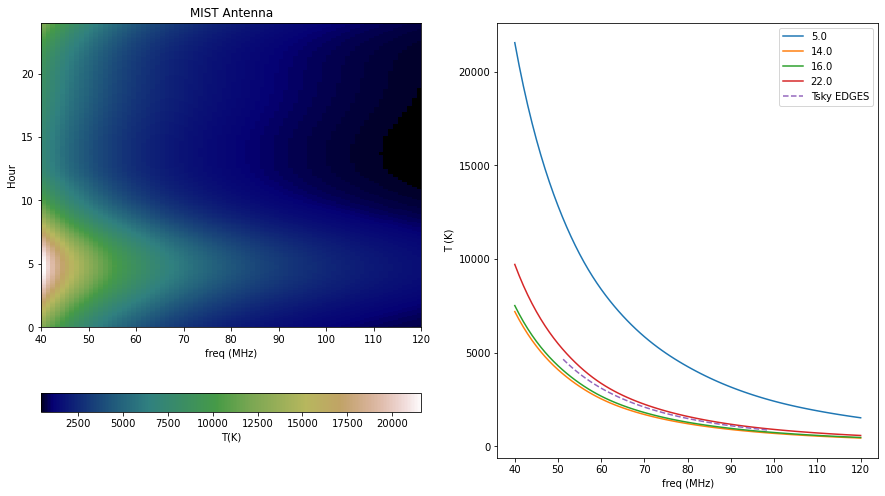

In [76]:
figure(figsize=(15,8))
subplot(1,2,1)
pcolormesh(f,hours, TG_I,cmap='gist_earth')
colorbar(label='T(K)',orientation="horizontal")
title("MIST Antenna"),ylabel('Hour'),xlabel('freq (MHz)')
subplot(1,2,2)
[plot(f,TG_I[i],label=i/10) for i in ([50,140,160,220])],legend(),xlabel('freq (MHz)'),ylabel('T (K)')
plot(fig1['Freq'],fig1['Tsky'],'--',label='Tsky EDGES')
#xlim([50,80]),ylim([1000,4000])
legend()

C:\Users\msmm1\AppData\Local\Temp/ipykernel_5428/4022819251.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolormesh(f,hours, TG_I,cmap='gist_earth')
C:\Users\msmm1\AppData\Local\Temp/ipykernel_5428/4022819251.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolormesh(f,hours, TG_B,cmap='gist_earth')
C:\Users\msmm1\AppData\Local\Temp/ipykernel_5428/4022819251.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions 

([[<matplotlib.lines.Line2D at 0x22f112f8790>]],
 Text(0.5, 0, 'freq (MHz)'),
 Text(0, 0.5, 'T (K)'))

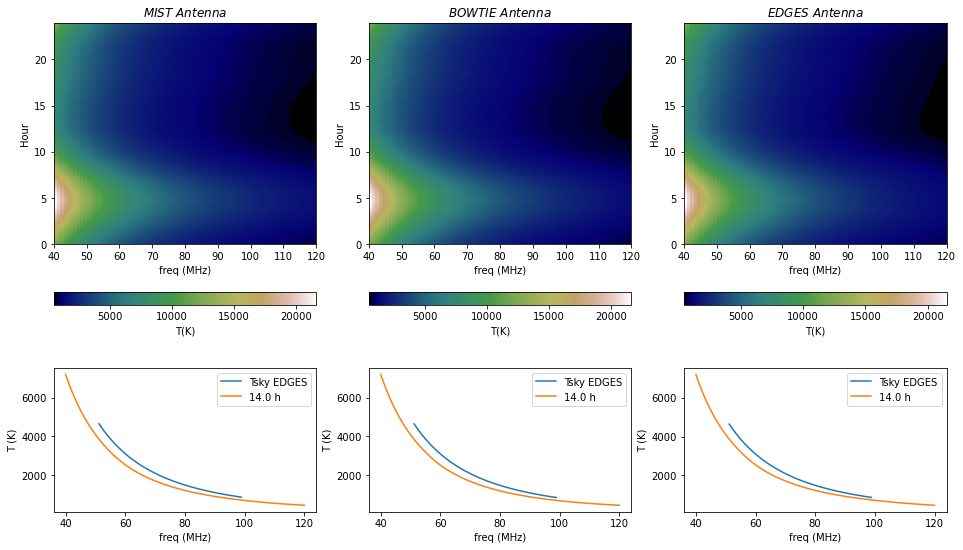

In [77]:
figure(figsize=(16,9))
subplot2grid((3,3), (0,0),rowspan=2)
pcolormesh(f,hours, TG_I,cmap='gist_earth')
colorbar(label='T(K)',orientation="horizontal")
title("$MIST\ Antenna$"),xlabel('freq (MHz)'),ylabel('Hour')

subplot2grid((3,3), (0,1),rowspan=2)
pcolormesh(f,hours, TG_B,cmap='gist_earth')
colorbar(label='T(K)',orientation="horizontal")
title("$BOWTIE\ Antenna$"),ylabel('Hour'),xlabel('freq (MHz)')

subplot2grid((3,3), (0,2),rowspan=2)
pcolormesh(f,hours, TG_E,cmap='gist_earth')
colorbar(label='T(K)',orientation="horizontal")
title("$EDGES\ Antenna$"),ylabel('Hour'),xlabel('freq (MHz)')

subplot2grid((3,3), (2,0))
plot(fig1['Freq'],fig1['Tsky'],label='Tsky EDGES')
[plot(f,TG_I[i],label='{}{}'.format(i/10, " h")) for i in ([140])],legend(),xlabel('freq (MHz)'),ylabel('T (K)')

subplot2grid((3,3), (2,1))
plot(fig1['Freq'],fig1['Tsky'],label='Tsky EDGES')
[plot(f,TG_B[i],label='{}{}'.format(i/10, " h")) for i in ([140])],legend(),xlabel('freq (MHz)'),ylabel('T (K)')

subplot2grid((3,3), (2,2))
plot(fig1['Freq'],fig1['Tsky'],label='Tsky EDGES')
[plot(f,TG_E[i],label='{}{}'.format(i/10, " h")) for i in ([140])],legend(),xlabel('freq (MHz)'),ylabel('T (K)')

In [55]:
shape(TG_I)

(240, 81)